## Table of Content:
* [Data Preparation & Visualisation](#data-prep-viz)
* [Machine Learning](#ml)

In [82]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from skimpy import skim
import math
from scipy.stats import binom

from matplotlib.pyplot import figure
import calendar

import fitter

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Preparation & Visualisation <a class="anchor" id="data-prep-viz"></a>

## Helper Functions

In [3]:
NUMPY_INTS = [np.dtypes.Float64DType, np.dtypes.Float32DType, np.dtypes.Int64DType, np.dtypes.Int32DType]

# Based on the URL provided, fetch_data will featch the data and put it into the output path
# The output will be in CSV format
def fetch_data(url, out_file):
  res = requests.get(url)
  if res.content:
    with open(out_file, "w") as csv_file:
      writer = csv.writer(csv_file)
      content = res.content.decode("utf-8").split("\n")
      for line in content:
        line = [entry.replace('"', '').replace('\r', '') for entry in line.split(",")]
        writer.writerow(line)

# Returns a cleaned up dataframe with columns dropped and column names converted into 'variable name' like format
def do_basic_cleanup(df, drop_cols):
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    return df

# returns a series with Value counts, where values are processed depending on value type. Should probably try tocast them too.
# https://www.kaggle.com/code/parulpandey/five-ways-to-use-value-counts
def value_counts(df):
    res = []
    for col in df.columns:
      preliminary_res = df[col].value_counts()
      if preliminary_res.size > 20:
        if type(df[col].dtype) in NUMPY_INTS:
          preliminary_res = df[col].value_counts(bins=10)
          preliminary_res.name = preliminary_res.name + "- BINNED"
        else:
          preliminary_res = df[col].value_counts(normalize=True)  
          preliminary_res.name = preliminary_res.name + "- NORMALIZED"
      res.append(preliminary_res)
    return res


In [20]:
# Source: https://data.cso.ie/table/ASA02
fetch_data("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/ASA02/CSV/1.0/en", "irl_tourism.csv")

In [4]:
df = pd.read_csv("irl_tourism.csv", on_bad_lines='warn')
df.head(10)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02293V02763,Direction,C03042V03675,Route,UNIT,VALUE
0,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,-,All routes of travel,Thousand,12902.2
1,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,01,Cross channel,Thousand,6113.0
2,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,02,Continental Europe,Thousand,5652.6
3,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,03,Transatlantic,Thousand,914.5
4,ASA02,Air and Sea Travel,2010.0,2010.0,1.0,Arrivals,04,Other,Thousand,222.1
5,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,-,All routes of travel,Thousand,12920.2
6,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,01,Cross channel,Thousand,6132.4
7,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,02,Continental Europe,Thousand,5643.3
8,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,03,Transatlantic,Thousand,924.3
9,ASA02,Air and Sea Travel,2010.0,2010.0,2.0,Departures,04,Other,Thousand,220.3


In [5]:
df = do_basic_cleanup(df, ["STATISTIC", "STATISTIC Label", "TLIST(A1)", "C02293V02763", "C03042V03675", "UNIT"])

df = df.dropna()
df = df.astype({"year": int})
df.head()

,year,direction,route,value
0,2010,Arrivals,All routes of travel,12902.2
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1


In [6]:
#df.apply(lambda col: col.value_counts(), axis=1)
#skim(df)
df['value'].value_counts(bins=7)
print(type(df['value'].dtype))

(128.722, 3074.486]       64
(5999.771, 8925.057]      33
(3074.486, 5999.771]      12
(11850.343, 14775.629]    10
(17700.914, 20626.2]       8
(8925.057, 11850.343]      7
(14775.629, 17700.914]     6
Name: count, dtype: int64

<class 'numpy.dtypes.Float64DType'>


## Exploring arrivals from different destinations 

In [7]:
r_arrivals_df = df[(df['direction'] == 'Arrivals') & (df['route'] != 'All routes of travel')]

In [8]:
r_arrivals_df.head()

,year,direction,route,value
1,2010,Arrivals,Cross channel,6113.0
2,2010,Arrivals,Continental Europe,5652.6
3,2010,Arrivals,Transatlantic,914.5
4,2010,Arrivals,Other,222.1
11,2011,Arrivals,Cross channel,6102.5


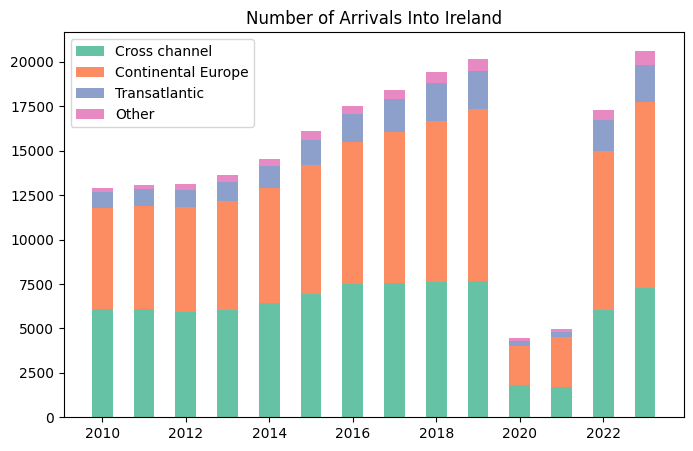

In [9]:
#sns.set_theme(style="whitegrid")

#ax = sns.barplot(data=arrivals, x="year", y="value", hue="route", palette='flare')

x = r_arrivals_df['year'].unique()
routes = r_arrivals_df['route'].unique()
bottom = np.zeros(len(x))
palette = sns.color_palette("Set2")

_, ax= plt.subplots(figsize=(8, 5))
width = 0.5

#for year in x:
for i, route in enumerate(routes):
   data = r_arrivals_df[r_arrivals_df['route'] == route]['value']
   _ = ax.bar(x, data, width, label=route, bottom=bottom, color=palette[i])
   bottom += data.to_numpy()

_ = ax.set_title("Number of Arrivals Into Ireland")
_ = ax.legend(loc="upper left")

plt.savefig('figures/Arrivals Per Route Stacked.png', bbox_inches='tight', dpi=400);

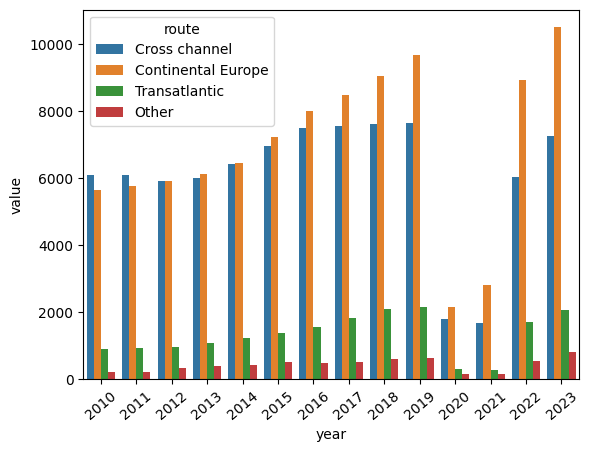

In [11]:
a = sns.barplot(data=r_arrivals_df, x='year', y='value', hue='route')
a.tick_params(axis='x', labelrotation=40);
plt.savefig('figures/Arrivals Per Route.png', bbox_inches='tight');

## Explore percent change Year over Year

In [12]:
arrivals_cols = r_arrivals_df.set_index(['year', 'route'])['value'].unstack()
for c in arrivals_cols.columns.to_numpy():
    arrivals_cols['PTC'+c] = round(arrivals_cols[c].pct_change() * 100, 2)
    arrivals_cols = arrivals_cols.drop(columns=[c])
    
arrivals_cols = arrivals_cols.reset_index()
arrivals_pct_change = arrivals_cols.melt(id_vars='year')

arrivals_pct_change['route'] = arrivals_pct_change['route'].apply(lambda r: r.replace("PTC", ""))
arrivals_pct_change.rename(columns={'value': 'pct_change'}, inplace=True)
arrivals_pct_change.fillna(0, inplace=True)

arrivals = r_arrivals_df.merge(arrivals_pct_change, on=['year', 'route'], how='inner')

In [13]:
arrivals.head(5)

,year,direction,route,value,pct_change
0,2010,Arrivals,Cross channel,6113.0,0.00
1,2010,Arrivals,Continental Europe,5652.6,0.00
2,2010,Arrivals,Transatlantic,914.5,0.00
3,2010,Arrivals,Other,222.1,0.00
4,2011,Arrivals,Cross channel,6102.5,-0.17


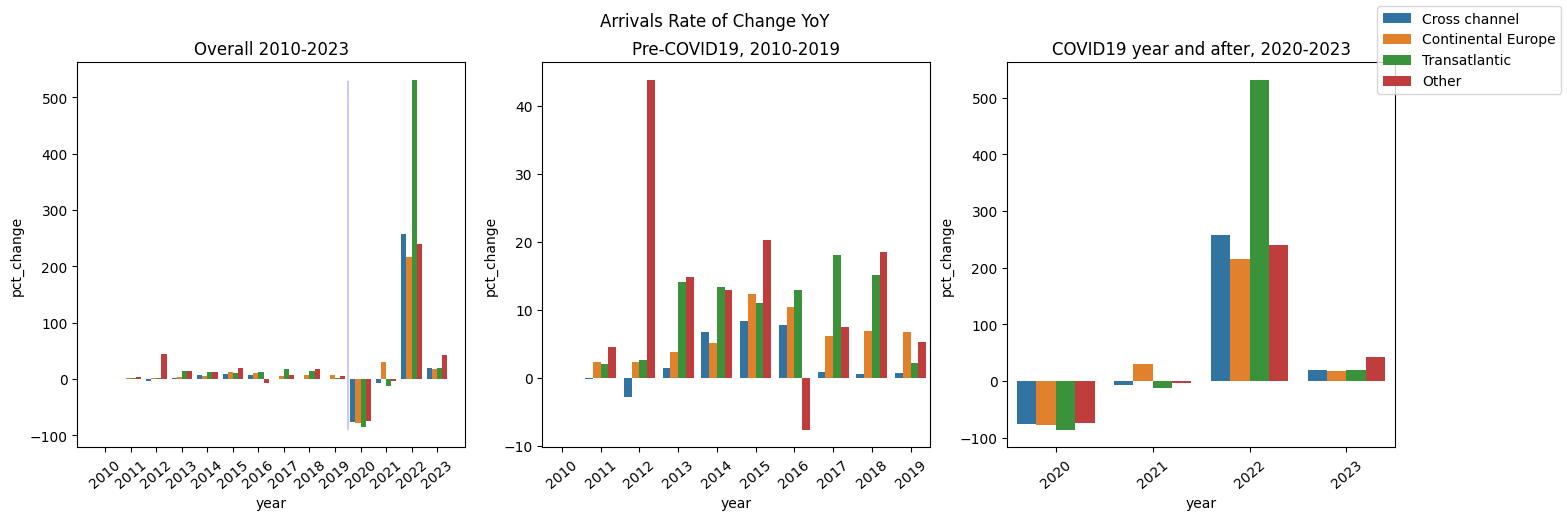

In [14]:
f, axes = plt.subplots(1, 3, figsize=(17, 5))

_ = sns.barplot(data=arrivals, x='year', y='pct_change', hue='route', ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=40);
axes[0].set_title('Overall 2010-2023');
axes[0].plot([9.5,9.5], [-90,530], 'b-', linewidth = 0.3);
axes[0].get_legend().remove();

_ = sns.barplot(data=arrivals.loc[(arrivals['year'] < 2020)], x='year', y='pct_change', hue='route', ax=axes[1])
axes[1].tick_params(axis='x', labelrotation=40);
axes[1].set_title('Pre-COVID19, 2010-2019');
axes[1].get_legend().remove();

_ = sns.barplot(data=arrivals.loc[(arrivals['year'] >= 2020)], x='year', y='pct_change', hue='route', ax=axes[2])
axes[2].tick_params(axis='x', labelrotation=40);
axes[2].set_title('COVID19 year and after, 2020-2023');
axes[2].get_legend().remove();

h, l = axes[0].get_legend_handles_labels();
f.legend(h, l, loc='upper right');
f.suptitle('Arrivals Rate of Change YoY');

plt.savefig('figures/Arrivals Rate of Change YoY.png', bbox_inches='tight');

## Flights to Ireland from other international airports
1. Data from https://ec.europa.eu/eurostat/web/transport/data/database
2. https://ec.europa.eu/eurostat/databrowser/explore/all/transp?lang=en&subtheme=avia.avia_pa.avia_par&display=list&sort=category&extractionId=avia_par_ie
3. Explanatory notes on the data https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en
4. API https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true

|Dimension	| Agency : Code list | Values |
| --- | --- | --- |
|FREQ | Time frequency	ESTAT : FREQ | Annual, Quarterly, Monthly ||
|UNIT | Unit of measure	ESTAT : UNIT | Passenger, Flights, Seats and berths||
|TRA_MEAS | Traffic and transport measurement	ESTAT : TRA_MEAS ||
|AIRP_PR | Airport pairs (routes)	ESTAT : AIRP_PR ||
|OBS_FLAG | Observation status (Flag)	ESTAT : OBS_FLAG ||

In [31]:
#IRL_AIRPORT_PASS_TRAVEL = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT/avia_par_ie$defaultview/1.0?references=descendants&detail=referencepartial&format=sdmx_2.1_generic&compressed=true"
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=SDMX-CSV&lang=en&label=both
# https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/avia_par_ie/?format=TSV
# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

# https://ec.europa.eu/eurostat/databrowser/view/avia_par_ie/default/table?lang=en&category=avia.avia_pa.avia_par

### ONLY REPLAY IF DATASET IS MISSING< IT IS VERY BIG
# fetch_data("https://ec.europa.eu/eurostat/api/dissemination/sdmx/3.0/data/dataflow/ESTAT/avia_par_ie/1.0?compress=false&format=csvdata&formatVersion=2.0&lang=en&labels=name", 
#            "flights.csv")

In [15]:
# Cannot commit the dataset to GitHub, as it is beyond the file size allowd by GH
# Replay the previous step to generate the dataset
# low_memory=False due to mixed datatypes
flights = pd.read_csv("flights.csv", low_memory=False)

In [16]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)
#flights.columns
flights.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,freq,Time frequency,unit,Unit of measure,tra_meas,Traffic and transport measurement,airp_pr,Airport pairs (routes),TIME_PERIOD,Time,OBS_VALUE,Observation value,OBS_FLAG,Observation status (Flag)
0,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2012,NaN,256.0,NaN,NaN,NaN
1,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_BE_EBBR,CORK airport - BRUSSELS airport,2013,NaN,248.0,NaN,NaN,NaN
2,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CH_LSZH,CORK airport - ZURICH airport,2019,NaN,213.0,NaN,NaN,NaN
3,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2003,NaN,296.0,NaN,NaN,NaN
4,dataflow,ESTAT:AVIA_PAR_IE(1.0),Air passenger transport between the main airpo...,A,Annual,FLIGHT,Flight,CAF_PAS,Commercial passenger air flights,IE_EICK_CZ_LKPR,CORK airport - PRAHA/RUZYNE airport,2004,NaN,557.0,NaN,NaN,NaN


In [18]:
# Remove column repetitions
flights = do_basic_cleanup(flights, ["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", 
                                     "freq", 'unit', 'Time', 'Observation value', 'Observation status (Flag)', 'OBS_FLAG', 'tra_meas', 'Airport pairs (routes)'])

In [19]:
flights.dtypes
flights.value_counts()

time_frequency                        object
unit_of_measure                       object
traffic_and_transport_measurement     object
airp_pr                               object
time_period                           object
obs_value                            float64
dtype: object

time_frequency  unit_of_measure   traffic_and_transport_measurement        airp_pr          time_period  obs_value
Annual          Flight            Commercial passenger air flights         IE_EICK_BE_EBBR  2012         256.0        1
Monthly         Seats and berths  Passengers seats available (arrivals)    IE_EIDW_ES_LERS  2012-04      6237.0       1
                                                                                            2015-08      8434.0       1
                                                                                            2015-07      12119.0      1
                                                                                            2015-06      11718.0      1
                                                                                                                     ..
                Passenger         Passengers carried (arrival)             IE_EIDW_UK_EGNT  2010-06      5373.0       1
                                             

In [20]:
flights_m = flights[flights['time_frequency'] == 'Monthly']

In [21]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True
flights_m[['year', 'month']] = flights_m['time_period'].str.split('-', expand=True)
flights_m = flights_m.drop(columns=['time_period', 'time_frequency'])

In [22]:
flights_m.head(2)

,unit_of_measure,traffic_and_transport_measurement,airp_pr,obs_value,year,month
31623,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,6.0,2012,03
31624,Flight,Commercial passenger air flights,IE_EICK_BE_EBBR,26.0,2012,04


In [23]:
#flights_m[['year', 'quarter']] = flights_m['time_period'].str.split('-', expand=True)
#flights_m[['domestic_airport', 'international_airport']] 
flights_m['airp_pr'].apply(lambda x: len(x)).value_counts()

# Same lengths, so we can attempt to split the pairs
flights_m['domestic_airport']  = flights_m['airp_pr'].apply(lambda x: x[:7])
flights_m['international_airport'] = flights_m['airp_pr'].apply(lambda x: x[8:15])
flights_m.drop(columns=['airp_pr'], inplace=True)

flights_m['domestic_airport'].value_counts()
flights_m['international_airport'].value_counts()

airp_pr
15    370798
Name: count, dtype: int64

domestic_airport
IE_EIDW    217466
IE_EICK     60768
IE_EINN     54716
IE_EIKN     22844
IE_EIKY     12016
IE_EICM      2988
Name: count, dtype: int64

international_airport
UK_EGSS    14119
UK_EGCC    12208
UK_EGKK    10485
UK_EGBB    10410
ES_GCRR     9855
           ...  
US_KDFW       84
UK_EGAA       66
ZZ_ZZZZ       65
EL_LGIR       54
UK_EGHD       36
Name: count, Length: 141, dtype: int64

In [24]:
flights_m.head(2)

,unit_of_measure,traffic_and_transport_measurement,obs_value,year,month,domestic_airport,international_airport
31623,Flight,Commercial passenger air flights,6.0,2012,03,IE_EICK,BE_EBBR
31624,Flight,Commercial passenger air flights,26.0,2012,04,IE_EICK,BE_EBBR


In [25]:
# res = requests.get('https://gist.githubusercontent.com/ssskip/5a94bfcd2835bf1dea52/raw/3b2e5355eb49336f0c6bc0060c05d927c2d1e004/ISO3166-1.alpha2.json')
# take this maybe?

res = requests.get('https://gist.githubusercontent.com/fogonwater/bc2b98baeb2aa16b5e6fbc1cf3d7d545/raw/6fd2951260d8f171181a45d2f09ee8b2c7767330/countries.json')
country_codes = json.loads(res.content.decode("utf-8"))

In [26]:
country_codes['PL']

{'continent_code': 'EU',
 'continent_name': 'Europe',
 'country_code2': 'PL',
 'country_code3': 'POL',
 'country_name': 'Poland',
 'country_name_full': 'Republic of Poland',
 'iso3': '616'}

In [27]:
# According to https://www.destatis.de/Europa/EN/Country/Country-Codes.html Greece is assigned GR country code, however, on Eurostate it is EL
# In our countries mapping, we only have GR, so we can add an entry for Greece in our `country_codes`
# GB (Eurostat: UK)
# Add aliases for EL and UK, which are actually GR and GB

country_codes['EL'] = {'continent_code': 'EU',
  'continent_name': 'Europe',
  'country_code2': 'GR',
  'country_code3': 'GRC',
  'country_name': 'Greece'}

country_codes['UK'] = {   "continent_code": "EU",
    "continent_name": "Europe",
    "country_code2": "GB",
    "country_code3": "GBR",
    "country_name": "United Kingdom of Great Britain & Northern Ireland",
    "country_name_full": "United Kingdom of Great Britain & Northern Ireland",
    "iso3": "826"
  }

In [28]:
flights_m['country_code'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['country_name'] if x[0:2] in country_codes else x[0:2])

flights_m['continent_name'] = flights_m['international_airport'].apply(
    lambda x: country_codes[x[0:2]]['continent_name'] if x[0:2] in country_codes else x[0:2])

# Select only European flights
flights_m = flights_m.loc[(flights_m['continent_name'] == 'Europe')]

flights_m['obs_value'] = flights_m['obs_value'].astype(int)

#flights_m = flights_m.drop(columns=[''])

In [29]:
# Extract the rows that correspond to the measurements that need to be turned into columns
passengers_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Passenger') & ((flights_m['traffic_and_transport_measurement'] == 'Passengers on board (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Passengers on board (departures)'))]
seats_available_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Seats and berths') & ((flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Passengers seats available (departures)'))]
flights_month = flights_m.loc[(flights_m['unit_of_measure'] == 'Flight') & ((flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (arrivals)') | (flights_m['traffic_and_transport_measurement'] == 'Commercial passenger air flights (departures)'))]



In [30]:
passengers_month.rename(columns={"obs_value": "num_passangers"}, inplace=True)
seats_available_month.rename(columns={"obs_value": "total_capacity"}, inplace=True)
flights_month.rename(columns={"obs_value": "num_flights"}, inplace=True)

In [31]:
component_dfs = [passengers_month, flights_month, seats_available_month]

for df in component_dfs:
  df.drop(columns=['unit_of_measure', 'continent_name'], inplace=True)
  df['traffic_and_transport_measurement'] = df["traffic_and_transport_measurement"].apply(lambda x: 'arrivals' if 'arrivals' in x else 'departures')
  df.rename(columns={"traffic_and_transport_measurement": "direction"}, inplace=True)
  
  # Check the Arrivals / Departures transform did not result in losing any values
  df['direction'].isna().value_counts()

direction
False    53702
Name: count, dtype: int64

direction
False    53667
Name: count, dtype: int64

direction
False    53702
Name: count, dtype: int64

In [32]:
for df in component_dfs:
  df.head(1)
  df.tail(1)

for df in component_dfs:
  df.shape

,direction,num_passangers,year,month,domestic_airport,international_airport,country_code
152840,arrivals,271,2012,03,IE_EICK,BE_EBBR,Belgium


,direction,num_passangers,year,month,domestic_airport,international_airport,country_code
212551,departures,10308,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


,direction,num_flights,year,month,domestic_airport,international_airport,country_code
61956,arrivals,3,2012,03,IE_EICK,BE_EBBR,Belgium


,direction,num_flights,year,month,domestic_airport,international_airport,country_code
121597,departures,75,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


,direction,total_capacity,year,month,domestic_airport,international_airport,country_code
341842,arrivals,522,2012,03,IE_EICK,BE_EBBR,Belgium


,direction,total_capacity,year,month,domestic_airport,international_airport,country_code
401553,departures,14411,2023,10,IE_EINN,UK_EGSS,United Kingdom of Great Britain & Northern Ire...


(53702, 7)

(53667, 7)

(53702, 7)

In [33]:
shapes = {
    'passengers_arr_month': passengers_month.shape[0],
    'seats_available_arr_month': seats_available_month.shape[0],
    'flights_arr_month': flights_month.shape[0],
}
shapes

{'passengers_arr_month': 53702,
 'seats_available_arr_month': 53702,
 'flights_arr_month': 53667}

In [34]:
# Since the dataframes differ in size, do an outer join to ensure we have all values for now
keys = ['year', 'month', 'direction', 'domestic_airport', 'international_airport', 'country_code']
merged_df = passengers_month.merge(seats_available_month, on=keys, how='outer')
merged_df = merged_df.merge(flights_month, on=keys, how='outer')


In [35]:
merged_df = merged_df.reindex(columns=['year','month', 'direction',	'domestic_airport','international_airport', 'country_code', 'num_passangers','total_capacity','num_flights'])


In [36]:
merged_df.describe()

,num_passangers,total_capacity,num_flights
count,53702.000000,53702.000000,53667.000000
mean,8045.957339,10614.599438,65.367023
std,10292.840343,13425.164627,80.270933
min,0.000000,0.000000,1.000000
25%,2368.000000,3253.000000,22.000000
50%,4732.000000,5866.000000,37.000000
75%,9187.000000,11734.000000,75.000000
max,100056.000000,134374.000000,1123.000000


In [37]:
# Select Only top 3 Irish airport 
merged_df = merged_df.loc[((merged_df['domestic_airport'] == 'IE_EIDW') | (merged_df['domestic_airport'] == 'IE_EICK') | (merged_df['domestic_airport'] == 'IE_EINN'))]

In [38]:
merged_df.shape

(47411, 9)

In [39]:
merged_df['pct_occupancy'] = round(merged_df['num_passangers'] / merged_df['total_capacity'], 3)
merged_df['pct_occupancy'].isna().value_counts()
merged_df.loc[((merged_df['pct_occupancy'] == np.inf) | (merged_df['pct_occupancy'] == np.inf))].pct_occupancy.value_counts()

merged_df = merged_df.astype({"month": int})
merged_df = merged_df.astype({"year": int})

merged_df.sort_values(by=['year', 'month'])

merged_df.dtypes


pct_occupancy
False    47378
True        33
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

,year,month,direction,domestic_airport,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy
176,2003,1,arrivals,IE_EICK,ES_GCLP,Spain,1476,1478,8.0,0.999
355,2003,1,arrivals,IE_EICK,ES_GCRR,Spain,2665,2665,14.0,1.000
993,2003,1,arrivals,IE_EICK,ES_LEMG,Spain,1141,2020,15.0,0.565
1438,2003,1,arrivals,IE_EICK,FR_LFPG,France,2160,3960,30.0,0.545
1686,2003,1,arrivals,IE_EICK,IE_EIDW,Ireland,8661,17301,233.0,0.501
...,...,...,...,...,...,...,...,...,...,...
52524,2023,10,departures,IE_EINN,UK_EGCC,United Kingdom of Great Britain & Northern Ire...,3824,5981,31.0,0.639
52952,2023,10,departures,IE_EINN,UK_EGKK,United Kingdom of Great Britain & Northern Ire...,4864,5898,31.0,0.825
53173,2023,10,departures,IE_EINN,UK_EGLL,United Kingdom of Great Britain & Northern Ire...,11351,15515,87.0,0.732
53383,2023,10,departures,IE_EINN,UK_EGPH,United Kingdom of Great Britain & Northern Ire...,2472,4088,21.0,0.605


year                       int64
month                      int64
direction                 object
domestic_airport          object
international_airport     object
country_code              object
num_passangers             int64
total_capacity             int64
num_flights              float64
pct_occupancy            float64
dtype: object

In [40]:
merged_df['domestic_airport'].value_counts()
merged_df.describe()
merged_df.shape

domestic_airport
IE_EIDW    30402
IE_EICK     9934
IE_EINN     7075
Name: count, dtype: int64

,year,month,num_passangers,total_capacity,num_flights,pct_occupancy
count,47411.000000,47411.000000,47411.000000,47411.000000,47376.000000,47378.000000
mean,2013.018456,6.502963,8753.448271,11498.376031,70.300912,0.767102
std,5.855010,3.386794,10739.446099,14020.242991,83.657801,0.150400
min,2003.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2008.000000,4.000000,2829.000000,3828.000000,23.000000,0.689000
50%,2013.000000,7.000000,5231.000000,6748.000000,42.000000,0.787000
75%,2018.000000,9.000000,10093.000000,13129.000000,83.000000,0.878000
max,2023.000000,12.000000,100056.000000,134374.000000,651.000000,1.066000


(47411, 10)

In [41]:
merged_df.replace([np.inf, -np.inf, 0], np.nan, inplace=True)

## Statistics

### Binomial

In a hypothetical scenario, the airlines have an avarage profit margin at 75% flight occupancy rate, while <75 percent being a loss and >75 being a profit. 

In [42]:
gain = merged_df
gain['gain'] = merged_df['pct_occupancy'].apply(lambda x: 0 if x <= 0.75 else 1)

# arrivals = merged_df.loc[(merged_df['direction'] == 'arrivals')]
# departures = merged_df.loc[(merged_df['direction'] == 'departures')]


In [43]:
# need to do frequency count
print('Overall')
value_counts = gain['gain'].value_counts()
relative_frequencies = value_counts/len(merged_df)
relative_frequencies

print('January')
january_df = gain.loc[(gain['month']==1)]
value_counts = january_df['gain'].value_counts()
relative_frequencies = value_counts/len(january_df)
relative_frequencies

print('July')
june_df = gain.loc[(merged_df['month']==7)]
value_counts = june_df['gain'].value_counts()
relative_frequencies = value_counts/len(june_df)
relative_frequencies

Overall


gain
1    0.602371
0    0.397629
Name: count, dtype: float64

January


gain
0    0.690096
1    0.309904
Name: count, dtype: float64

July


gain
1    0.804925
0    0.195075
Name: count, dtype: float64

In [44]:
loss_p = 0.397629
profit_p = 0.602371

# 100 flights arrive at the Dublin / Shannon / Cork airport
print('Calculate probability of up to 30 of those 100 flights are operating  at a loss:\n',
      'Overall: ', round(binom.cdf(k=30, n=100, p=0.397629), 4), '\n',
      'In January: ', round(binom.cdf(k=30, n=100, p=0.690096), 4), '\n',
      'In July: ', round(binom.cdf(k=30, n=100, p=0.195075), 4), '\n',
      )

print('Calculate probability exactly up to 30 of those 100 flights are operating  at a loss:\n',
      'Overall: ', round(binom.pmf(k=30, n=100, p=0.397629), 4), '\n',
      'In January: ', round(binom.pmf(k=30, n=100, p=.690096), 4), '\n',
      'In July: ', round(binom.pmf(k=30, n=100, p=0.195075), 4), '\n',
      )

print('Calculate probability of over 30 of those 100 flights are operating  at a loss:\n',
      'Overall: ', round(binom.sf(k=30, n=100, p=0.397629), 4), '\n',
      'In January: ', round(binom.sf(k=30, n=100, p=.690096), 4), '\n',
      'In July: ', round(binom.sf(k=30, n=100, p=0.195075), 4), '\n',
      )

Calculate probability of up to 30 of those 100 flights are operating  at a loss:
 Overall:  0.0277 
 In January:  0.0 
 In July:  0.9959 

Calculate probability exactly up to 30 of those 100 flights are operating  at a loss:
 Overall:  0.011 
 In January:  0.0 
 In July:  0.0038 

Calculate probability of over 30 of those 100 flights are operating  at a loss:
 Overall:  0.9723 
 In January:  1.0 
 In July:  0.0041 



In [45]:
value_counts = gain['country_code'].value_counts()
relative_frequencies = value_counts/len(gain)
relative_frequencies

country_code
United Kingdom of Great Britain & Northern Ireland    0.324566
Spain                                                 0.186159
Poland                                                0.071439
Germany                                               0.062897
France                                                0.062644
Italy                                                 0.056105
Portugal                                              0.034802
Netherlands                                           0.028474
Ireland                                               0.024678
Belgium                                               0.022105
Switzerland                                           0.018055
Lithuania                                             0.016916
Czech Republic                                        0.012529
Hungary                                               0.011221
Denmark                                               0.010314
Austria                                   

In [46]:


print('Among 1000 random traveller going throuhg the passport control on any given day calculate the probability that at least 100 of them are coming from a flight from United Kingdom of Great Britain & Northern Ireland',
      round(binom.cdf(k=100 , n=1000, p=0.063070), 3))


print('Among 1000 random traveller going throuhg the passport control on any given day calculate the probability that at least 100 of them are coming from a flight from Iceland',
      round(binom.cdf(k=500 , n=1000, p=0.002953), 3))

Among 1000 random traveller going throuhg the passport control on any given day calculate the probability that at least 100 of them are coming from a flight from United Kingdom of Great Britain & Northern Ireland 1.0
Among 1000 random traveller going throuhg the passport control on any given day calculate the probability that at least 100 of them are coming from a flight from Iceland 1.0


Plot Flight Occupancy distribution month over month

/var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_35774/3462654942.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(calendar.month_name)[1:])


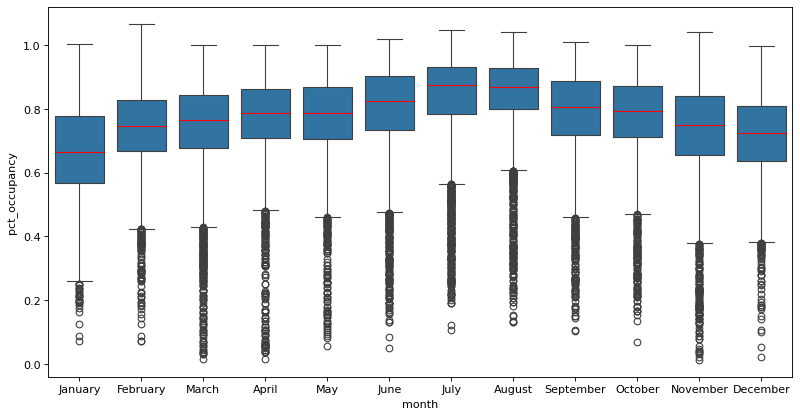

In [63]:
figure(figsize=(12, 6), dpi=80)
ax = sns.boxplot(data=merged_df, y="pct_occupancy", x="month", medianprops={"color": "r", "linewidth": 1})
ax.set_xticklabels(list(calendar.month_name)[1:])

plt.savefig('figures/Percent Flight Occupancy Per Month.png');

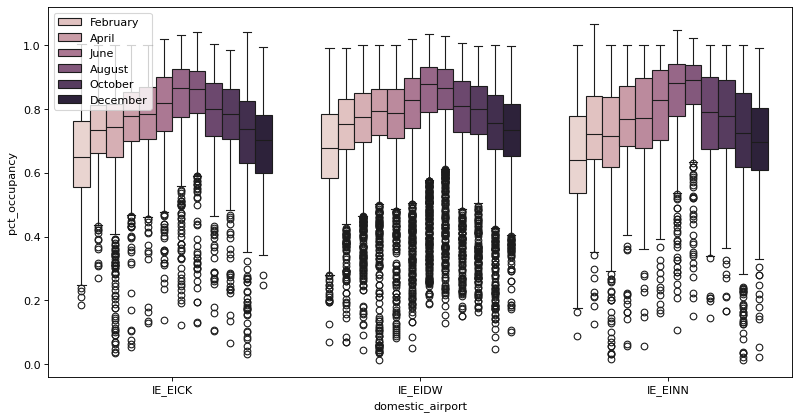

In [64]:

figure(figsize=(12, 6), dpi=80);
ax = sns.boxplot(data=merged_df, y="pct_occupancy", x="domestic_airport", hue='month')
handles, _ = ax.get_legend_handles_labels();
ax.legend(handles, list(calendar.month_name)[2::2], loc="best");

plt.savefig('figures/Percent Flight Occupancy Per Month Per Airport.png');

Plot flight occupancy distibution per destination country and domestic airport

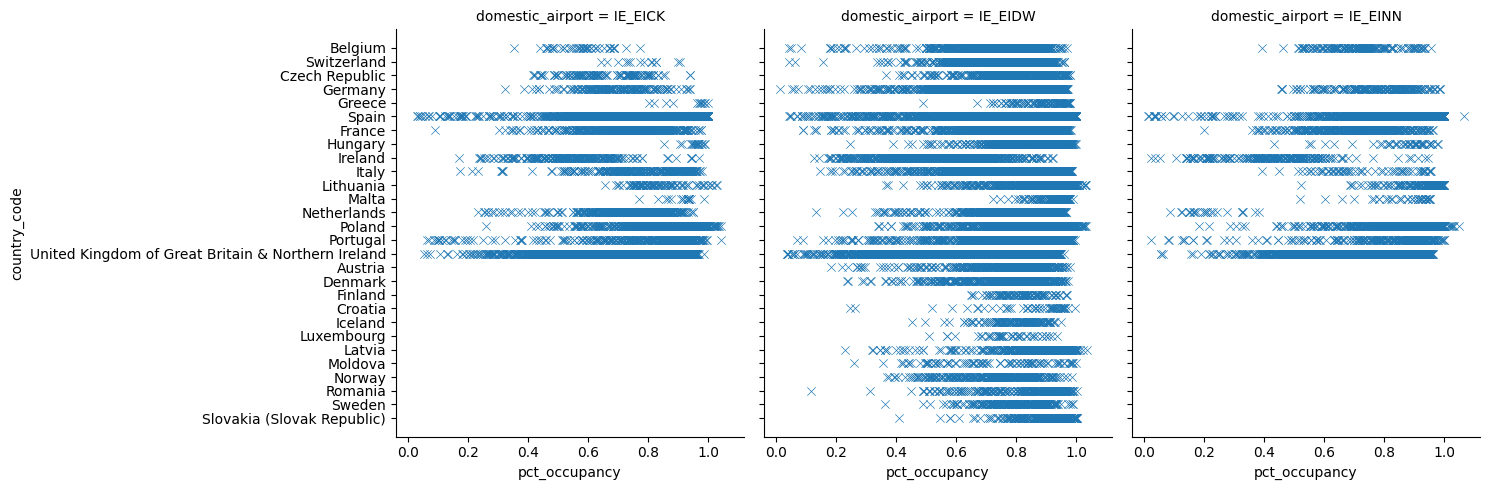

In [65]:
_ = sns.relplot(data=merged_df, x="pct_occupancy", y="country_code", col='domestic_airport', marker='x')
plt.savefig('figures/Percent Flight Occupancy By Country By Airport.png');

Percent occupancy distribution

<Figure size 800x240 with 0 Axes>

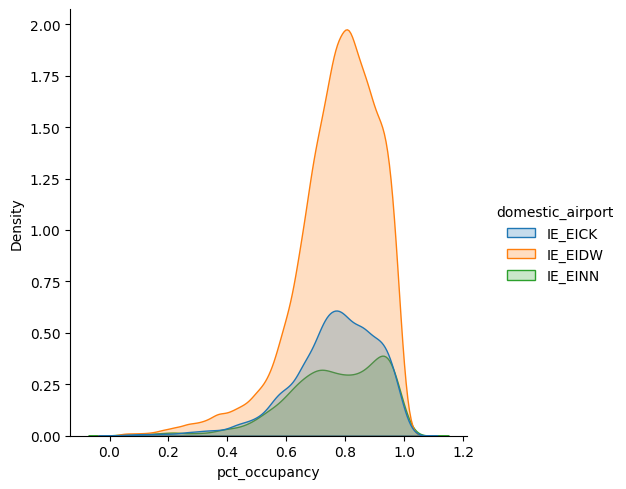

In [67]:
figure(figsize=(10, 3), dpi=80);
sns.displot(data=merged_df, x='pct_occupancy', hue='domestic_airport', kind='kde', fill=True)
plt.savefig('figures/Displot Percent Occupancy By Airport.png');

2024-04-02 20:35:18.700 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.0)


2024-04-02 20:35:20.984 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.0)
2024-04-02 20:35:21.417 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.0)
2024-04-02 20:35:21.921 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.0)
2024-04-02 20:35:25.599 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.0)
2024-04-02 20:35:26.020 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.0)
2024-04-02 20:35:26.365 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.0)
2024-04-02 20:35:40.473 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.0)
2024-04-02 20:35:43.014 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted chi2 distribution with error=0.0)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,2.199077e-09,2775.921073,2802.220902,inf,0.018874,4.219384e-15
expon,8.529432e-09,2961.787847,2979.321066,inf,0.068557,3.366012e-194
cauchy,9.148865e-09,2811.367134,2828.900353,inf,0.172506,0.000000e+00
rayleigh,2.409977e-08,4044.525677,4062.058896,inf,0.223183,0.000000e+00
norm,3.043982e-08,4245.174030,4262.707249,inf,0.207277,0.000000e+00


{'lognorm': {'s': 0.9538770359353405,
  'loc': -278.9537564926065,
  'scale': 5701.2340138423715}}

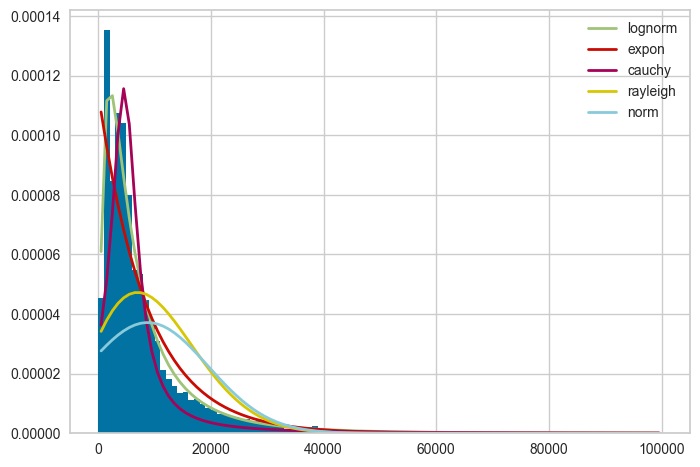

In [85]:
f = fitter.Fitter(merged_df['num_passangers'].values, distributions=fitter.get_common_distributions())

f.fit()
f.summary()

f.get_best(method='sumsquare_error')

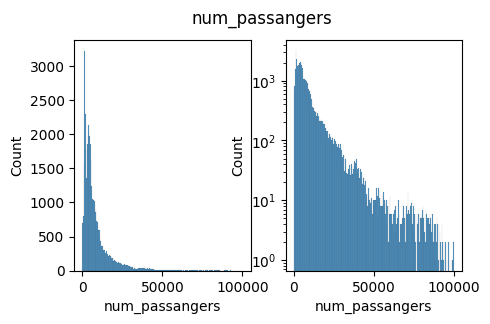

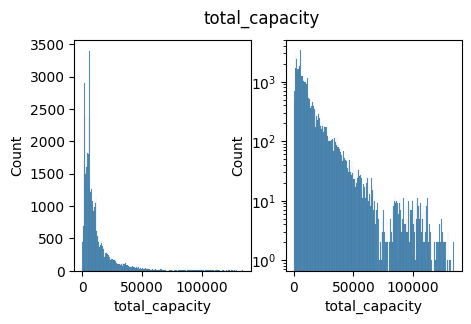

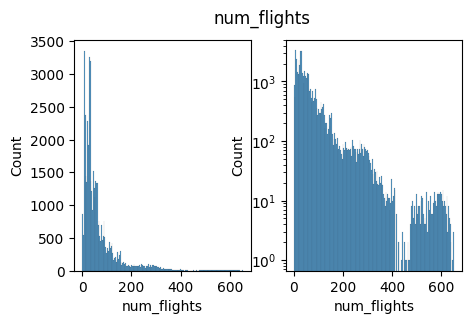

In [52]:
COLS_TO_SCALE = ['num_passangers', 'total_capacity', 'num_flights']

for col in COLS_TO_SCALE:
    f, sca = plt.subplots(1, 2, figsize=(5, 3))
    _ = sns.histplot(data=merged_df_processed, x=col, ax=sca[0])
    _ = sns.histplot(data=merged_df_processed, x=col, ax=sca[1])
    sca[1].set_yscale('log')
    #ax[1].set_xscale('log')
    _ = f.suptitle(col)
    plt.savefig('figures/Counts and Log for {col}.png'.format(col=col.replace('_', ' ').title()), bbox_inches='tight');


## Preprocessing

In [48]:
import matplotlib.image as mpimg
from sklearn.impute import SimpleImputer

In [49]:
merged_df_processed = merged_df

merged_df_processed.head()
merged_df_processed.columns

,year,month,direction,domestic_airport,international_airport,country_code,num_passangers,total_capacity,num_flights,pct_occupancy,gain
0,2012,3,arrivals,IE_EICK,BE_EBBR,Belgium,271.0,522.0,3.0,0.519,0
1,2012,4,arrivals,IE_EICK,BE_EBBR,Belgium,1346.0,2262.0,13.0,0.595,0
2,2012,5,arrivals,IE_EICK,BE_EBBR,Belgium,1377.0,2262.0,13.0,0.609,0
3,2012,6,arrivals,IE_EICK,BE_EBBR,Belgium,1082.0,2262.0,13.0,0.478,0
4,2012,7,arrivals,IE_EICK,BE_EBBR,Belgium,1550.0,2262.0,13.0,0.685,0


Index(['year', 'month', 'direction', 'domestic_airport',
       'international_airport', 'country_code', 'num_passangers',
       'total_capacity', 'num_flights', 'pct_occupancy', 'gain'],
      dtype='object')

#### Imputing missing data

In [50]:
imputer = SimpleImputer(strategy='mean')
merged_df_processed['num_passangers'] = imputer.fit_transform(merged_df_processed['num_passangers'].values.reshape(-1, 1) )
merged_df_processed['total_capacity'] = imputer.fit_transform(merged_df_processed['total_capacity'].values.reshape(-1, 1) )
merged_df_processed['num_flights'] = imputer.fit_transform(merged_df_processed['num_flights'].values.reshape(-1, 1) )

#### Scaling

In [51]:
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)

In [74]:
# Comparing different scaling methods
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

X_to_scale = merged_df_processed[COLS_TO_SCALE]

scaler_results = [
    ("Unscaled data", X_to_scale),
    ("Standard scaling", StandardScaler().fit_transform(X_to_scale)),
    ("Min-max scaling", MinMaxScaler().fit_transform(X_to_scale)),
    ("Max-abs scaling", MaxAbsScaler().fit_transform(X_to_scale)),
    ("Robust scaling", RobustScaler(quantile_range=(25, 75)).fit_transform(X_to_scale)),
    #("Power transformation (Yeo-Johnson)", PowerTransformer(method="yeo-johnson").fit_transform(X_to_scale)),
    ("Quantile transformation Uniform PDF", QuantileTransformer(output_distribution="uniform", random_state=42).fit_transform(X_to_scale)),
    ("Quantile transformation Gaussian PDF", QuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_to_scale)),
    ("Sample-wise L2 normalizing", Normalizer().fit_transform(X_to_scale)),
]

In [76]:
names = []
for i, res in enumerate(scaler_results):
    name = 'scaler-graphs/' + str(i) + '-' + res[0].lower().replace(' ', '-') + '.png'
    names.append(name)

for i, res in enumerate(scaler_results):
    df = pd.DataFrame(res[1], columns=COLS_TO_SCALE)
    j = sns.jointplot(data=df, x="num_passangers", y="num_flights", height=4, ratio=2);
    _ = j.figure.suptitle(res[0])
    j.savefig(names[i])
    plt.close(names[i])

[None, None, None, None, None, None, None, None]

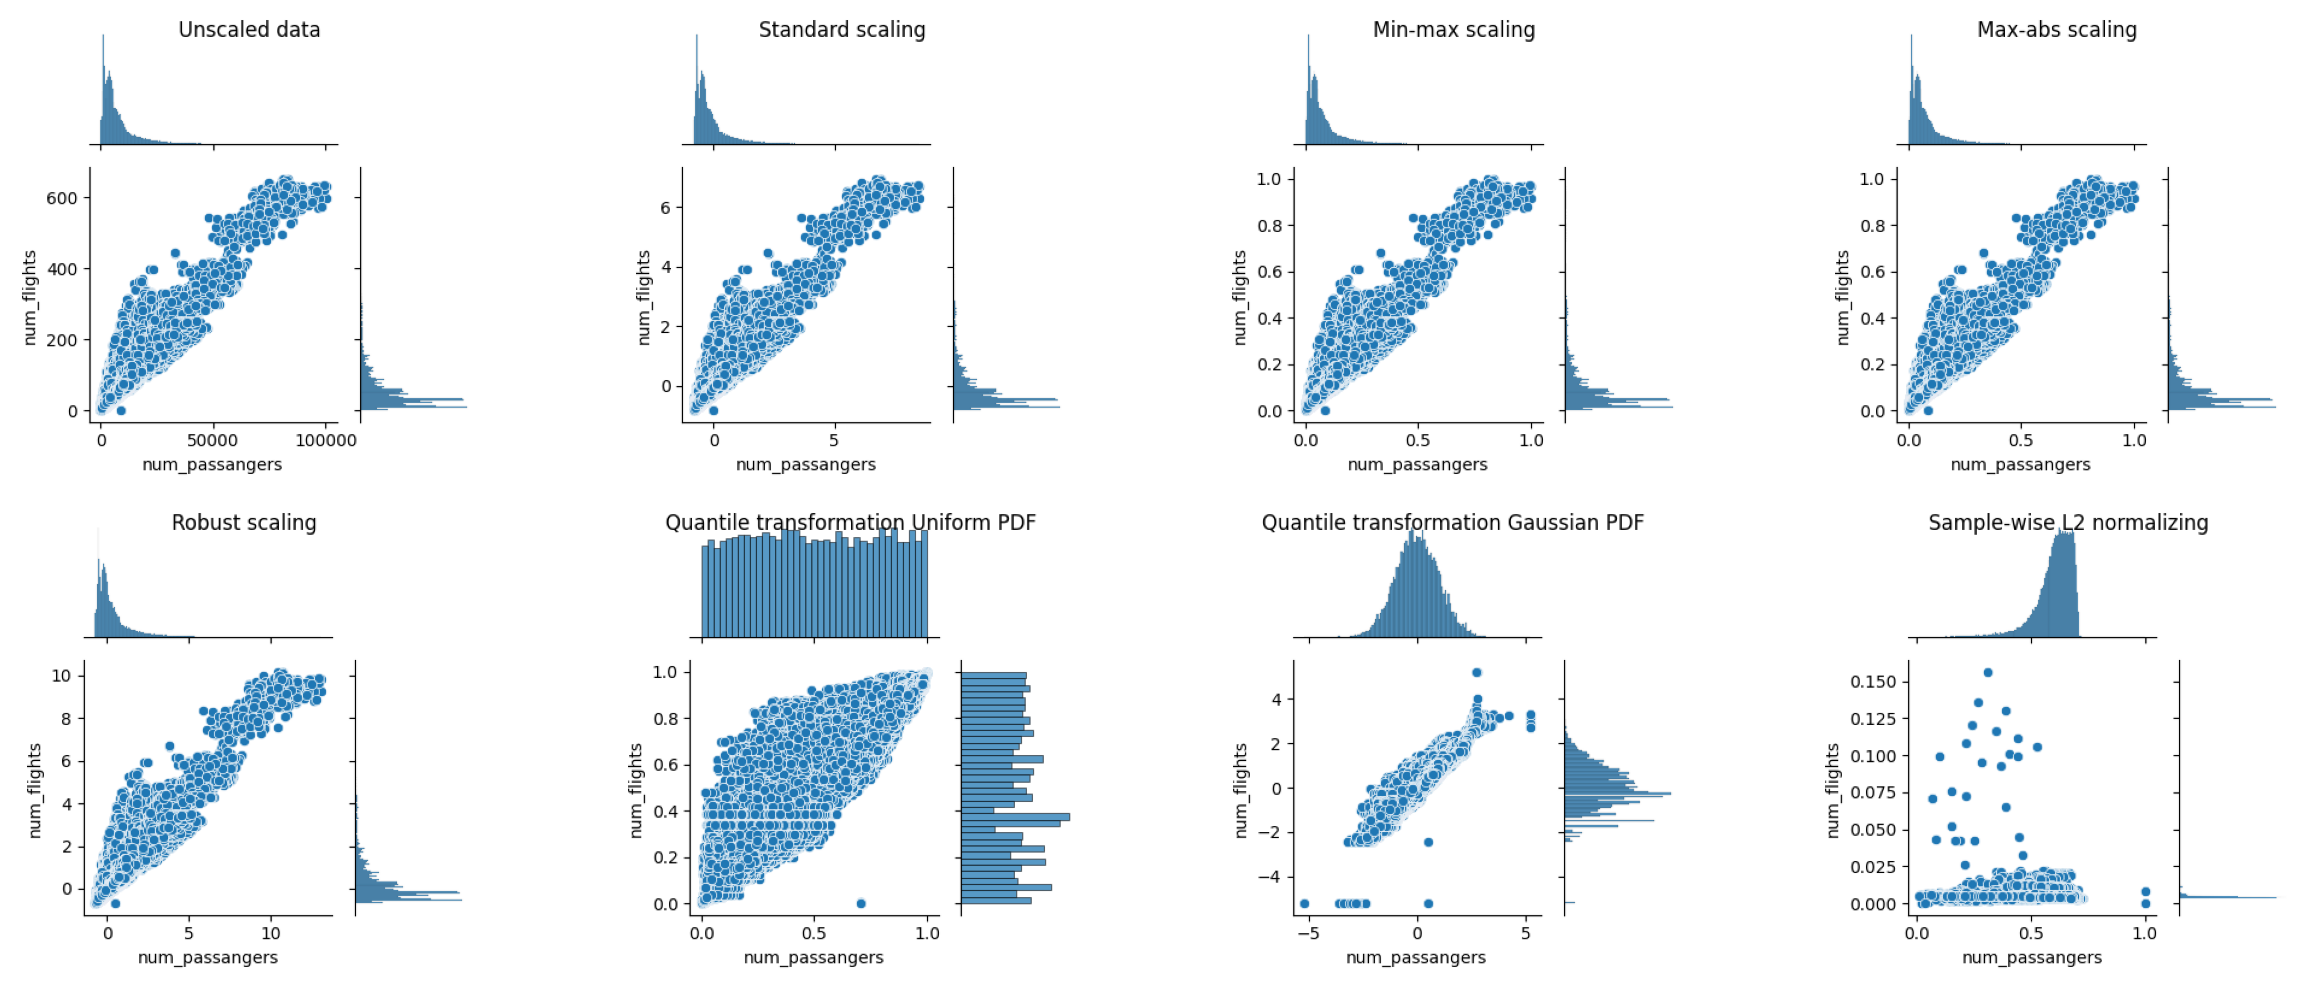

In [ ]:
# https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot - SOLUTION FROM HERE
f, axarr = plt.subplots(2, 4, figsize=(25, 10))

_ = axarr[0,0].imshow(mpimg.imread(names[0]))
_ = axarr[0,1].imshow(mpimg.imread(names[1]))
_ = axarr[0,2].imshow(mpimg.imread(names[2]))
_ = axarr[0,3].imshow(mpimg.imread(names[3]))
_ = axarr[1,0].imshow(mpimg.imread(names[4]))
_ = axarr[1,1].imshow(mpimg.imread(names[5]))
_ = axarr[1,2].imshow(mpimg.imread(names[6]))
_ = axarr[1,3].imshow(mpimg.imread(names[7]))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.savefig('figures/Scalers Visualisation.png')


## Machine Learning <a class="anchor" id="ml"></a>


### Split -> Encode -> Scale
Splitting data into dependent features and independednt variables

In [53]:
from sklearn.preprocessing import  OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from varname import nameof # For var name introspection


In [54]:
import sklearn

from imblearn.under_sampling import NearMiss

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings


In [90]:
# Spliting the dataset into independent and dependent variables

X_COLS = ['month', 
        'direction', 
        'international_airport',
        'num_passangers', 
        'total_capacity', 
        'num_flights']
X = merged_df_processed[X_COLS]

y = merged_df_processed['domestic_airport']

X.head()
y.head()

X['international_airport'].unique()

,month,direction,international_airport,num_passangers,total_capacity,num_flights
0,3,arrivals,BE_EBBR,271.0,522.0,3.0
1,4,arrivals,BE_EBBR,1346.0,2262.0,13.0
2,5,arrivals,BE_EBBR,1377.0,2262.0,13.0
3,6,arrivals,BE_EBBR,1082.0,2262.0,13.0
4,7,arrivals,BE_EBBR,1550.0,2262.0,13.0


0    IE_EICK
1    IE_EICK
2    IE_EICK
3    IE_EICK
4    IE_EICK
Name: domestic_airport, dtype: object

array(['BE_EBBR', 'CH_LSZH', 'CZ_LKPR', 'DE_EDDM', 'EL_LGIR', 'ES_GCLP',
       'ES_GCRR', 'ES_GCTS', 'ES_LEAL', 'ES_LEBL', 'ES_LEGE', 'ES_LEMG',
       'ES_LEPA', 'ES_LERS', 'ES_LEVC', 'FR_LFBD', 'FR_LFMN', 'FR_LFPG',
       'FR_LFPO', 'HU_LHBP', 'IE_EIDW', 'IE_EINN', 'IT_LIEA', 'IT_LIME',
       'IT_LIPH', 'IT_LIPZ', 'IT_LIRF', 'IT_LIRP', 'LT_EYVI', 'MT_LMML',
       'NL_EHAM', 'PL_EPGD', 'PL_EPKK', 'PL_EPKT', 'PL_EPPO', 'PL_EPWA',
       'PL_EPWR', 'PT_LPFR', 'PT_LPPT', 'UK_EGAC', 'UK_EGBB', 'UK_EGCC',
       'UK_EGFF', 'UK_EGGD', 'UK_EGGP', 'UK_EGGW', 'UK_EGHI', 'UK_EGKK',
       'UK_EGLC', 'UK_EGLL', 'UK_EGNT', 'UK_EGNX', 'UK_EGPF', 'UK_EGPH',
       'UK_EGPK', 'UK_EGSS', 'AT_LOWW', 'BE_EBCI', 'CH_LSGG', 'DE_EDDB',
       'DE_EDDF', 'DE_EDDH', 'DE_EDDK', 'DE_EDDL', 'DE_EDDS', 'DE_EDDT',
       'DE_EDFH', 'DE_EDSB', 'DK_EKCH', 'EL_LGAV', 'ES_GCFV', 'ES_LEBB',
       'ES_LELC', 'ES_LEMD', 'ES_LEMI', 'FI_EFHK', 'FR_LFBO', 'FR_LFLL',
       'FR_LFOB', 'FR_LFRS', 'HR_LDDU', 'IE_EICK', 

In [56]:
def split_encode_scale(X, y, scl, enc=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)):
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 82)

    # Feature encoding. Default param can be overridden with None, will need it for Tree models
    if enc:
        _ = enc.fit(X_train)
        X_train = enc.transform(X_train)
        X_test = enc.transform(X_test)

    # Encode labels with LabelEncoder, since this one accept a one-dimentional array
    lenc = LabelEncoder()
    y_train = lenc.fit_transform(y_train)
    y_test = lenc.transform(y_test)

    # For Trees scaling may degrade performance
    if scl:
        # Apply chosen scaler
        X_train = scl.fit_transform(X_train)
        X_test = scl.transform(X_test)

    return X_train, X_test, y_train, y_test


In [57]:
X_train, X_test, y_train, y_test = split_encode_scale(X, y, MinMaxScaler())
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((47411, 6), (47411,), (37928, 6), (37928,), (9483, 6), (9483,))

In [91]:
# Abstraction to run any classifier and plot confusion matrix.
# Will also do feature importance / permutation importances
def run_CFL(model, X_train, y_train, X_test, y_test, cols=X_COLS):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print("MODEL: ", model)
    print("Accuracy: ", metrics.accuracy_score(y_test, y_predict))
    print("Classification Report: \n", classification_report(y_test, y_predict))
    
    get_feature_imps_and_permutations(model, cols)

    cm = confusion_matrix(y_test, y_predict)    
    fig, ax = plt.subplots(figsize=(6,4), dpi=100)
    display = ConfusionMatrixDisplay(cm, display_labels=['IE_EICK', 'IE_EIDW', 'IE_EINN'])
    #plt.tick_params(axis='both',length=0)
    plt.grid(False)
    ax.set(title=f'Confusion Matrix for: {model}')
    display.plot(ax=ax);



def get_feature_imps_and_permutations(model, cols):
    if not cols:     # After one hot encoder I have a lot of columns and cannot do the feature importances 
        return
    
    if isinstance(model, sklearn.ensemble._forest.RandomForestClassifier):
        print("Feature Importances: \n")
        print(pd.Series(model.feature_importances_, index=X_COLS).
            plot(kind='barh', figsize=(3, 2), colormap='viridis'))
    
    if (isinstance(model, sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier) or 
        isinstance(model, sklearn.ensemble._forest.RandomForestClassifier)):
        print("Permutation Importances: \n")
        print(pd.Series(permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0).importances_mean.argsort(), index=X_COLS).
            plot(kind='barh', figsize=(3, 2), colormap='viridis'))
    
    if isinstance(model, sklearn.svm._classes.SVC):
        try: # Only SVC with liners kernel have coefficients
            print("Coefficient Importances: \n", model.coef_)
        except:
            pass


def run_GridSearch(model, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(model, params, n_jobs=2, verbose = 4)
    grid.fit(X_train, y_train)

    grid.best_params_
    grid.best_estimator_
    y_predict = grid.predict(X_test)
    
    res = '''\
    Best Params: {params}
    Best Estimator: {estimator} 
    Best Score: {score}

    Crosstab:\n
    {crosstab}

    Classification Report: \n
    {report}
            \
            '''.format(params=grid.best_params_, 
                       estimator=grid.best_estimator_, 
                       score=grid.best_score_, 
                       crosstab=pd.crosstab(y_test, y_predict, rownames = ['True'], colnames = ['Predicted'], margins = True).to_string(),
                       report=str(classification_report(y_test, y_predict))
                       )
    print(res)

    visualizer = ClassificationReport(model, classes=['IE_EICK', 'IE_EIDW', 'IE_EINN'], support=True, cmap='PuBuGn')
    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)     
    visualizer.show(outpath='cross-val/figures/{model}-{score}-ClassifReport.png'.format(model=model, score=str(grid.best_score_)))

    return res



### First Pass: Support Vector Classifier 

MODEL:  SVC()
Accuracy:  0.5982284087314141
Classification Report: 
               precision    recall  f1-score   support

           0       0.31      0.54      0.39      1933
           1       0.76      0.76      0.76      6085
           2       0.49      0.02      0.04      1465

    accuracy                           0.60      9483
   macro avg       0.52      0.44      0.40      9483
weighted avg       0.63      0.60      0.57      9483



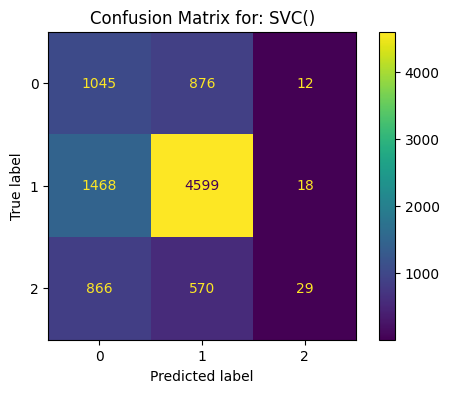

In [225]:
run_CFL(SVC(), X_train, y_train, X_test, y_test)

### Iteration 2: Try Balancing the dataset
I am working with an imbalanbced dataset, where the number of observations for the Dublin airport is over triple the other airports. Try to resample.

In [286]:
nr = NearMiss()

X_train_resampled, y_train_resampled = nr.fit_resample(X_train, y_train)
X_train_resampled.shape
y_train_resampled.shape

(16830, 6)

(16830,)

Re-try Support Vector Classifier

MODEL:  SVC()
Accuracy:  0.5071180006327112
Classification Report: 
               precision    recall  f1-score   support

           0       0.29      0.61      0.39      1933
           1       0.77      0.57      0.66      6085
           2       0.15      0.09      0.11      1465

    accuracy                           0.51      9483
   macro avg       0.40      0.43      0.39      9483
weighted avg       0.58      0.51      0.52      9483



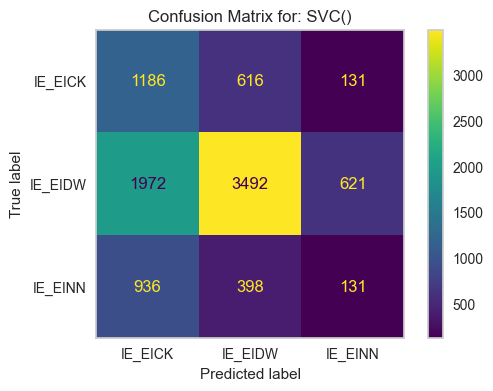

In [293]:
run_CFL(SVC(), X_train_resampled, y_train_resampled, X_test, y_test)

In [228]:
res = run_GridSearch(SVC(), 
                     {'C':[0.1,1,10],
                      'gamma':[1,0.1,0.01], 
                      'kernel':['rbf','linear','poly']},
                    X_train_resampled, y_train_resampled, X_test, y_test)

with open('cross-val/SVC-GridSearch.txt', 'w') as f:
    f.write(res)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.400 total time=  17.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.436 total time=  17.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.486 total time=  17.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.505 total time=  17.8s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.388 total time=   9.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.505 total time=  18.4s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.417 total time=  10.3s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.451 total time=  10.6s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.474 total time=  10.8s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.478 total time=  10.5s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.381 total time=  11.3s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

794

## Tree & Ensemble models

Decision Tree

MODEL:  DecisionTreeClassifier(max_depth=200, random_state=0)
Accuracy:  0.6800590530422862
Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.69      0.67      1933
           1       0.92      0.66      0.77      6085
           2       0.36      0.77      0.49      1465

    accuracy                           0.68      9483
   macro avg       0.65      0.70      0.64      9483
weighted avg       0.78      0.68      0.70      9483



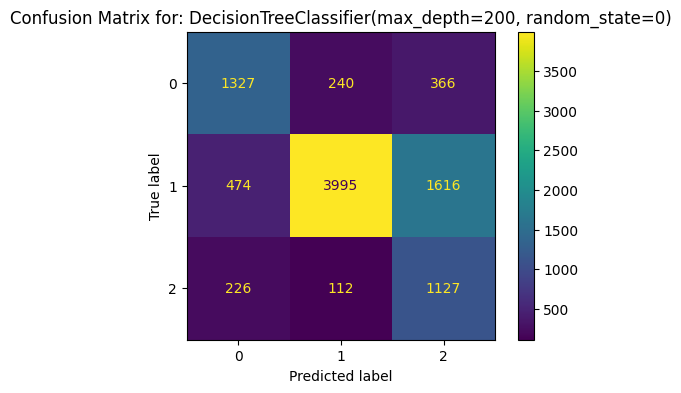

In [229]:
run_CFL(
    DecisionTreeClassifier(max_depth=200, random_state=0), 
    X_train_resampled, y_train_resampled, X_test, y_test
    )

Random Forest

MODEL:  RandomForestClassifier()
Accuracy:  0.6517979542338922
Classification Report: 
               precision    recall  f1-score   support

           0       0.45      0.65      0.53      1933
           1       0.90      0.62      0.74      6085
           2       0.46      0.78      0.58      1465

    accuracy                           0.65      9483
   macro avg       0.60      0.68      0.62      9483
weighted avg       0.74      0.65      0.67      9483

Feature Importances: 

Axes(0.125,0.11;0.775x0.77)
Permutation Importances: 

Axes(0.125,0.11;0.775x0.77)


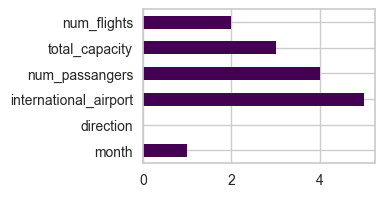

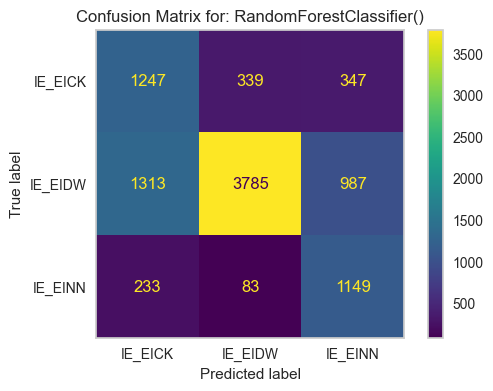

In [450]:

run_CFL(
    RandomForestClassifier(n_estimators=100), 
    X_train_resampled, y_train_resampled, X_test, y_test
    )

### Hyperparameter tuning
Random Forest Classifier seems to give the best results so far. I will thus, try and fine tune it and run cross validation grid search.


In [231]:
#### IMPORTANT ####
# Takes 59 mins to run
#### IMPORTANT ####
res = run_GridSearch(RandomForestClassifier(), 
                     { 'n_estimators': list(range(200,801,150)), # [200, 350, 500, 650, 800]
                       'max_features': ['sqrt', 'log2'],
                       'max_depth' : list(range(400,1201,400)), # [400, 800, 1200]
                       'criterion' :['gini', 'entropy']
                    },
                    X_train_resampled, y_train_resampled, X_test, y_test)

with open('cross-val/RandomForestClassifier-GridSearch.txt', 'w') as f:
    f.write(res)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[CV 1/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=200;, score=0.595 total time=   4.1s
[CV 2/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=200;, score=0.844 total time=   4.3s
[CV 3/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=200;, score=0.855 total time=   4.3s
[CV 4/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=200;, score=0.893 total time=   4.4s
[CV 5/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=200;, score=0.832 total time=   4.2s
[CV 1/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=350;, score=0.597 total time=   7.2s
[CV 2/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=350;, score=0.844 total time=   7.5s
[CV 3/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=350;, score=0.857 total time=   7.5s
[CV 4/5] END criterion=gini, max_depth=400, max_features=sqrt, n_estimators=350;, score=0.890 to

898

### Try an alternative: gradient boosted tree
https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting
This estimator is much faster than GradientBoostingClassifier for big datasets (n_samples >= 10 000).
This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. 

Compare agaist rad forest https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_hist_grad_boosting_comparison.html#sphx-glr-auto-examples-ensemble-plot-forest-hist-grad-boosting-comparison-py

#### HistGradientBoostingClassifier

MODEL:  HistGradientBoostingClassifier()
Accuracy:  0.7254033533691869
Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.67      0.65      1933
           1       0.93      0.72      0.81      6085
           2       0.44      0.82      0.57      1465

    accuracy                           0.73      9483
   macro avg       0.67      0.74      0.68      9483
weighted avg       0.80      0.73      0.74      9483

Permutation Importances: 

Axes(0.125,0.11;0.775x0.77)


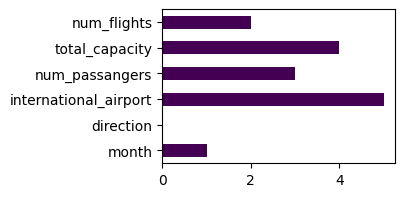

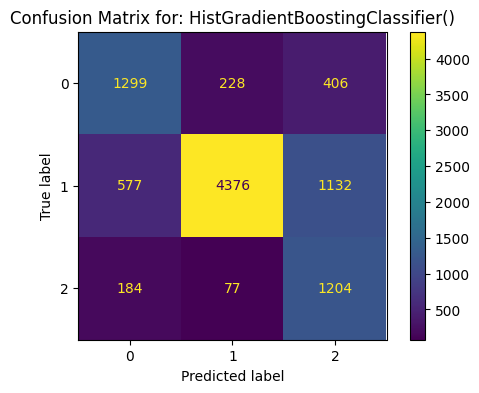

In [232]:

run_CFL(
    HistGradientBoostingClassifier(max_iter=100),
    X_train_resampled, y_train_resampled, X_test, y_test
)


In [233]:
res = run_GridSearch(HistGradientBoostingClassifier(), 
               {"max_iter": [10, 20, 50, 100, 300, 500]},
               X_train_resampled, y_train_resampled, X_test, y_test)

with open('cross-val/HistGradientBoostingClassifier-GridSearch.txt', 'w') as f:
    f.write(res)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5] END .......................max_iter=10;, score=0.812 total time=   0.3s
[CV 1/5] END .......................max_iter=10;, score=0.583 total time=   0.6s
[CV 3/5] END .......................max_iter=10;, score=0.801 total time=   0.3s


[CV 4/5] END .......................max_iter=10;, score=0.843 total time=   0.4s
[CV 5/5] END .......................max_iter=10;, score=0.744 total time=   0.3s
[CV 1/5] END .......................max_iter=20;, score=0.606 total time=   0.3s
[CV 2/5] END .......................max_iter=20;, score=0.837 total time=   0.3s
[CV 3/5] END .......................max_iter=20;, score=0.825 total time=   0.3s
[CV 4/5] END .......................max_iter=20;, score=0.871 total time=   0.3s
[CV 5/5] END .......................max_iter=20;, score=0.794 total time=   0.3s
[CV 1/5] END .......................max_iter=50;, score=0.638 total time=   0.7s
[CV 2/5] END .......................max_iter=50;, score=0.857 total time=   0.7s
[CV 3/5] END .......................max_iter=50;, score=0.865 total time=   0.7s
[CV 4/5] END .......................max_iter=50;, score=0.898 total time=   0.7s
[CV 5/5] END .......................max_iter=50;, score=0.816 total time=   0.7s
[CV 1/5] END ...............

799

Verify all results of Cross Validation for the 3 models above

In [235]:
with open('cross-val/SVC-GridSearch.txt') as f:
    print(f.read())

with open('cross-val/HistGradientBoostingClassifier-GridSearch.txt') as f:
    print(f.read())
    
with open('cross-val/RandomForestClassifier-GridSearch.txt') as f:
    print(f.read())



    Best Params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
    Best Estimator: SVC(C=10, gamma=1) 
    Best Score: 0.4874628639334522

    Crosstab:

    Predicted     0     1     2   All
True                             
0           961   614   358  1933
1          1864  3647   574  6085
2           634   403   428  1465
All        3459  4664  1360  9483

    Classification Report: 

                  precision    recall  f1-score   support

           0       0.28      0.50      0.36      1933
           1       0.78      0.60      0.68      6085
           2       0.31      0.29      0.30      1465

    accuracy                           0.53      9483
   macro avg       0.46      0.46      0.45      9483
weighted avg       0.61      0.53      0.55      9483

                        
    Best Params: {'max_iter': 500}
    Best Estimator: HistGradientBoostingClassifier(max_iter=500) 
    Best Score: 0.8450980392156863

    Crosstab:

    Predicted     0     1     2   All
True           

### Repeat with other scalers
HistGradientBoostingClassifier seems to show best performance, so it may be worth retrying with a different scaling method

#### Standard Scaler

In [236]:
X_train_std_scaler, X_test_std_scaler, y_train_std_scaler, y_test_std_scaler = split_encode_scale(X, y, StandardScaler())

# Resample the data after having applied the different scaler
nr = NearMiss()
X_train_std_scaler_resampled, y_train_std_scaler_resampled = nr.fit_resample(X_train_std_scaler, y_train_std_scaler)
X_train_std_scaler_resampled.shape
y_train_std_scaler_resampled.shape

(16830, 6)

(16830,)

MODEL:  SVC()
Accuracy:  0.4935147105346409
Classification Report: 
               precision    recall  f1-score   support

           0       0.32      0.51      0.39      1933
           1       0.78      0.53      0.64      6085
           2       0.20      0.30      0.24      1465

    accuracy                           0.49      9483
   macro avg       0.43      0.45      0.42      9483
weighted avg       0.60      0.49      0.52      9483



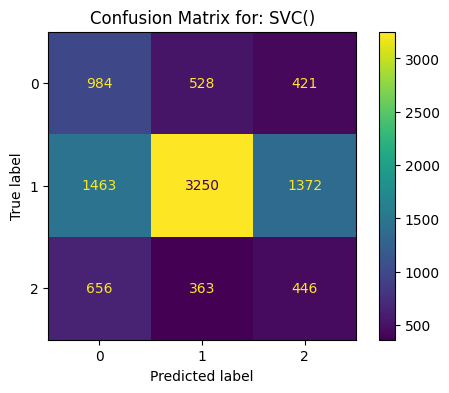

In [237]:
Xy_std_scaler_resampled = (X_train_std_scaler_resampled, y_train_std_scaler_resampled, X_test_std_scaler, y_test_std_scaler)

run_CFL(SVC(), *Xy_std_scaler_resampled)

MODEL:  DecisionTreeClassifier()
Accuracy:  0.678477275123906
Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.67      0.61      1933
           1       0.95      0.66      0.78      6085
           2       0.39      0.78      0.52      1465

    accuracy                           0.68      9483
   macro avg       0.63      0.70      0.63      9483
weighted avg       0.78      0.68      0.70      9483



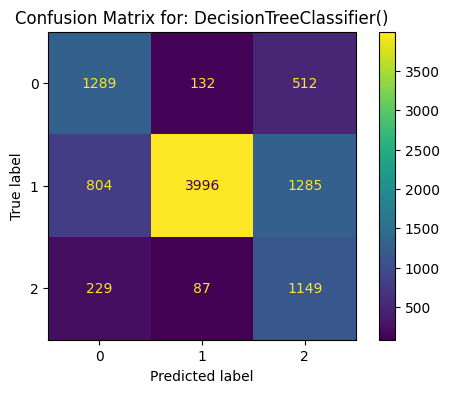

In [238]:
run_CFL(DecisionTreeClassifier(), *Xy_std_scaler_resampled)

MODEL:  RandomForestClassifier()
Accuracy:  0.6566487398502584
Classification Report: 
               precision    recall  f1-score   support

           0       0.48      0.66      0.56      1933
           1       0.91      0.62      0.74      6085
           2       0.43      0.79      0.56      1465

    accuracy                           0.66      9483
   macro avg       0.61      0.69      0.62      9483
weighted avg       0.75      0.66      0.67      9483

Feature Importances: 

Axes(0.125,0.11;0.775x0.77)
Permutation Importances: 

Axes(0.125,0.11;0.775x0.77)


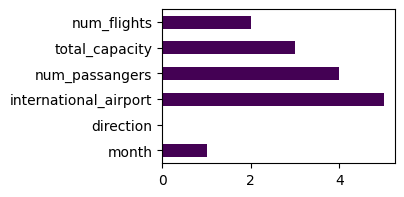

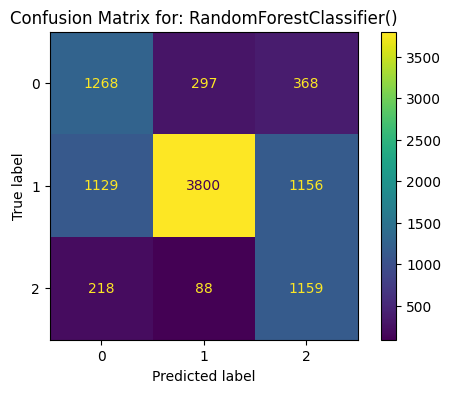

In [239]:
run_CFL(RandomForestClassifier(), *Xy_std_scaler_resampled)

MODEL:  HistGradientBoostingClassifier()
Accuracy:  0.7363703469366234
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.68      0.68      1933
           1       0.95      0.73      0.82      6085
           2       0.43      0.85      0.58      1465

    accuracy                           0.74      9483
   macro avg       0.69      0.75      0.69      9483
weighted avg       0.81      0.74      0.75      9483

Permutation Importances: 

Axes(0.125,0.11;0.775x0.77)


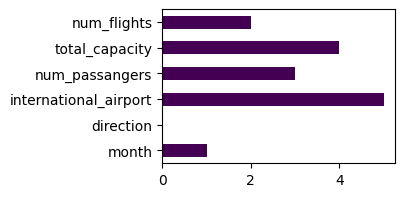

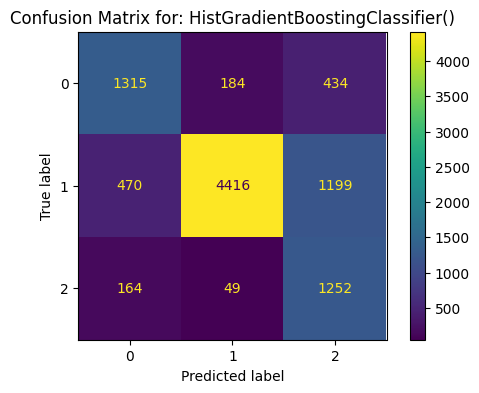

In [240]:
run_CFL(HistGradientBoostingClassifier(), *Xy_std_scaler_resampled)

#### QuantileTransformer

In [280]:
X_train_uniform_scaler, X_test_uniform_scaler, y_train_uniform_scaler, y_test_uniform_scaler = split_encode_scale(X, y, QuantileTransformer(output_distribution="uniform", random_state=42))

# Resample the data after having applied the different scaler
nr = NearMiss()
X_train_uniform_scaler_resampled, y_train_uniform_scaler_resampled = nr.fit_resample(X_train_uniform_scaler, y_train_uniform_scaler)
X_train_uniform_scaler_resampled.shape
y_train_uniform_scaler_resampled.shape

(16830, 6)

(16830,)

MODEL:  SVC()
Accuracy:  0.48792576188969733
Classification Report: 
               precision    recall  f1-score   support

           0       0.31      0.47      0.38      1933
           1       0.80      0.51      0.62      6085
           2       0.23      0.42      0.29      1465

    accuracy                           0.49      9483
   macro avg       0.45      0.47      0.43      9483
weighted avg       0.61      0.49      0.52      9483



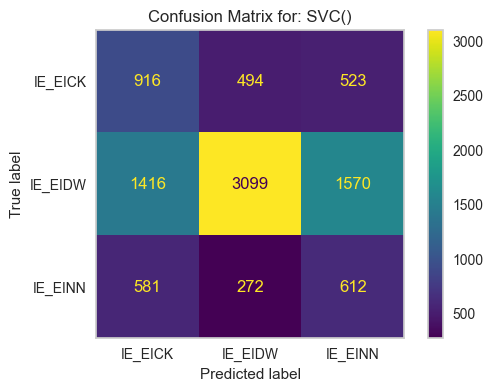

In [294]:
Xy_uniform_scaler_resampled = (X_train_uniform_scaler_resampled, y_train_uniform_scaler_resampled, X_test_uniform_scaler, y_test_uniform_scaler)

run_CFL(SVC(), *Xy_uniform_scaler_resampled)

MODEL:  DecisionTreeClassifier()
Accuracy:  0.804808604871876
Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.68      0.70      1933
           1       0.92      0.86      0.89      6085
           2       0.56      0.76      0.65      1465

    accuracy                           0.80      9483
   macro avg       0.73      0.76      0.74      9483
weighted avg       0.82      0.80      0.81      9483



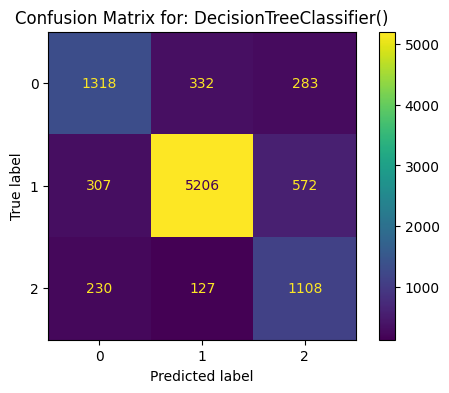

In [243]:
run_CFL(DecisionTreeClassifier(), *Xy_uniform_scaler_resampled)

MODEL:  RandomForestClassifier()
Accuracy:  0.7158072339976801
Classification Report: 
               precision    recall  f1-score   support

           0       0.62      0.64      0.63      1933
           1       0.91      0.72      0.80      6085
           2       0.44      0.81      0.57      1465

    accuracy                           0.72      9483
   macro avg       0.66      0.72      0.67      9483
weighted avg       0.78      0.72      0.73      9483

Feature Importances: 

Axes(0.125,0.11;0.775x0.77)
Permutation Importances: 

Axes(0.125,0.11;0.775x0.77)


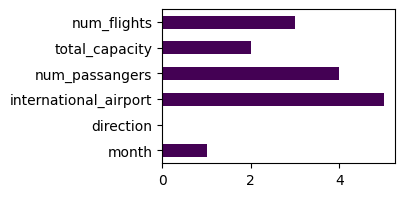

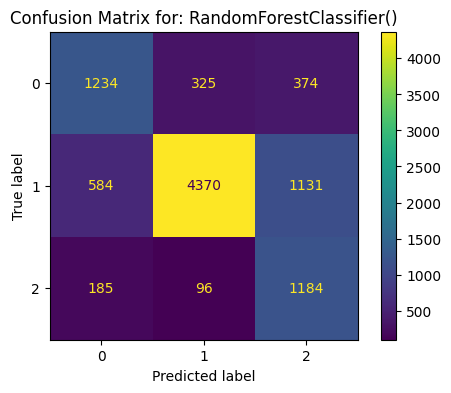

In [244]:
run_CFL(RandomForestClassifier(), *Xy_uniform_scaler_resampled)

MODEL:  HistGradientBoostingClassifier()
Accuracy:  0.7462828218918064
Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.66      0.64      1933
           1       0.94      0.75      0.83      6085
           2       0.49      0.86      0.62      1465

    accuracy                           0.75      9483
   macro avg       0.68      0.76      0.70      9483
weighted avg       0.80      0.75      0.76      9483

Permutation Importances: 

Axes(0.125,0.11;0.775x0.77)


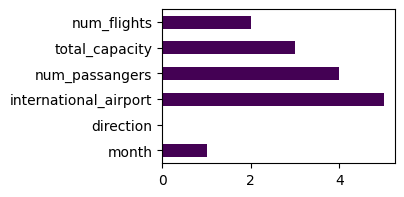

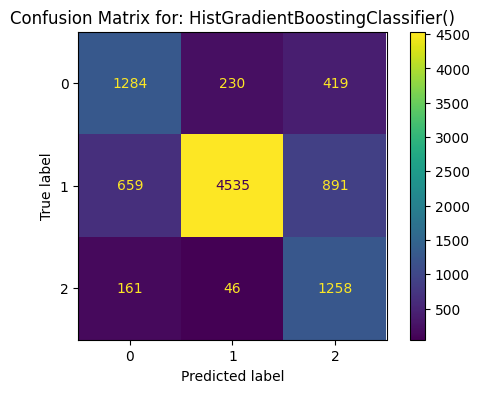

In [245]:
run_CFL(HistGradientBoostingClassifier(), *Xy_uniform_scaler_resampled)

### Fine-tuning the select model

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV 1/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=2;, score=0.385 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=2;, score=0.443 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=2;, score=0.470 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=2;, score=0.453 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=2;, score=0.402 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=4;, score=0.443 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=4;, score=0.385 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_leaf_nodes=3, min_samples_split=4;, score=0.470 total time=   0.0s
[CV 4/5] END criterion=gini, ma

[CV 5/5] END criterion=gini, max_depth=1, max_leaf_nodes=17, min_samples_split=10;, score=0.402 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=4;, score=0.402 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=2;, score=0.385 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=6;, score=0.385 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=2;, score=0.443 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=2;, score=0.470 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=6;, score=0.443 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=6;, score=0.470 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=1, max_leaf_nodes=19, min_samples_split=2;, scor

869

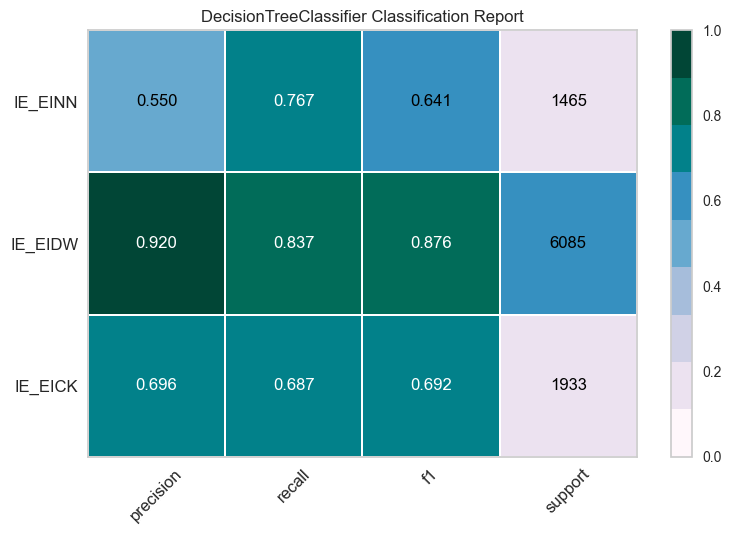

In [319]:
res = run_GridSearch(DecisionTreeClassifier(), 
                    {'criterion':['gini','entropy'],
                     'max_depth':np.arange(1,21).tolist()[0::2],
                     'min_samples_split':np.arange(2,11).tolist()[0::2],
                     'max_leaf_nodes':np.arange(3,26).tolist()[0::2]},
                    X_train_uniform_scaler_resampled, y_train_uniform_scaler_resampled, X_test_uniform_scaler, y_test_uniform_scaler)

with open('cross-val/DecisionTreeClassifier-UniformScaler-GridSearch.txt', 'w') as f:
    f.write(res)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 2/5] END .......................max_iter=10;, score=0.816 total time=   1.7s
[CV 1/5] END .......................max_iter=10;, score=0.630 total time=   1.7s
[CV 3/5] END .......................max_iter=10;, score=0.804 total time=   0.6s
[CV 4/5] END .......................max_iter=10;, score=0.835 total time=   0.6s
[CV 5/5] END .......................max_iter=10;, score=0.745 total time=   0.3s
[CV 1/5] END .......................max_iter=20;, score=0.633 total time=   0.5s
[CV 2/5] END .......................max_iter=20;, score=0.829 total time=   0.4s
[CV 3/5] END .......................max_iter=20;, score=0.835 total time=   0.3s
[CV 4/5] END .......................max_iter=20;, score=0.859 total time=   0.3s
[CV 5/5] END .......................max_iter=20;, score=0.789 total time=   0.3s
[CV 1/5] END .......................max_iter=50;, score=0.669 total time=   0.8s
[CV 2/5] END .......................max_iter=50;, score=0.857 total time=   0.8s
[CV 3/5] END ...............

799

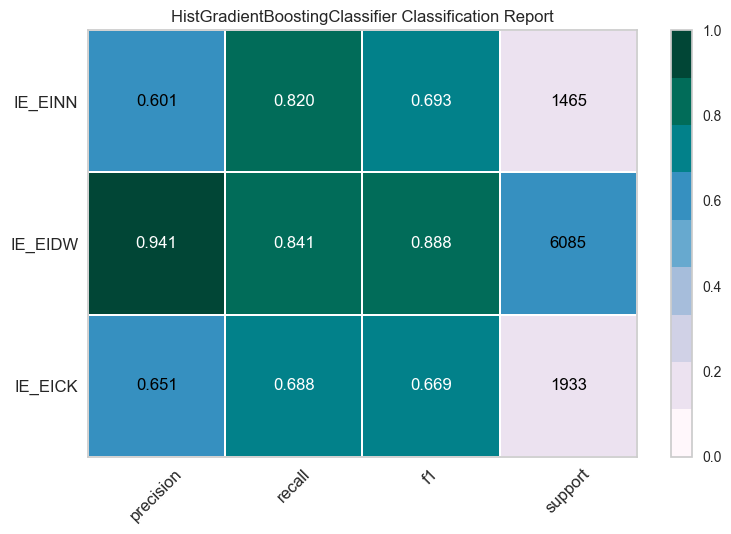

In [320]:
res = run_GridSearch(HistGradientBoostingClassifier(), 
                    {"max_iter": [10, 20, 50, 100, 300, 500]},
                    X_train_uniform_scaler_resampled, y_train_uniform_scaler_resampled, X_test_uniform_scaler, y_test_uniform_scaler)

with open('cross-val/HistGradientBoostingClassifier-UniformScaler-GridSearch.txt', 'w') as f:
    f.write(res)


Achieved 0.80 accurancy

### Standard Scaler & OneHot Encoder 

In [59]:
merged_df_sampled = merged_df_processed.sample(n=12000)
X_s = merged_df_sampled[X_COLS]
y_s = merged_df_sampled['domestic_airport']

X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = split_encode_scale(X_s, y_s, OneHotEncoder(sparse_output=False, handle_unknown="ignore"))

# Resample the data after having applied the different scaler
nr = NearMiss()
X_train_one_hot_resampled, y_train_one_hot_resampled = nr.fit_resample(X_train_one_hot, y_train_one_hot)
X_train_one_hot_resampled.shape
y_train_one_hot_resampled.shape

(4260, 13309)

(4260,)

In [60]:
Xy_one_hot_resampled = (X_train_one_hot_resampled, y_train_one_hot_resampled, X_test_one_hot, y_test_one_hot)

MODEL:  SVC()
Accuracy:  0.6325
Classification Report: 
               precision    recall  f1-score   support

           0       0.40      0.65      0.49       265
           1       0.91      0.62      0.74       767
           2       0.44      0.65      0.53       168

    accuracy                           0.63      1200
   macro avg       0.59      0.64      0.59      1200
weighted avg       0.73      0.63      0.66      1200



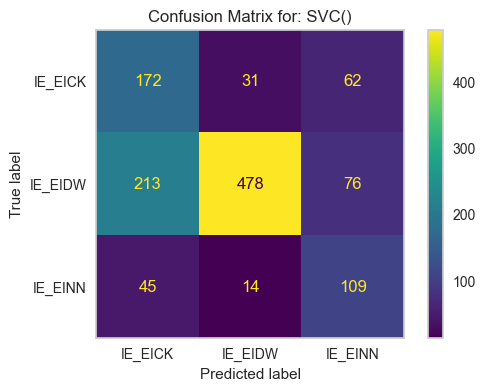

In [95]:
run_CFL(SVC(), *Xy_one_hot_resampled)

MODEL:  DecisionTreeClassifier()
Accuracy:  0.695
Classification Report: 
               precision    recall  f1-score   support

           0       0.47      0.64      0.54       265
           1       0.92      0.74      0.82       767
           2       0.43      0.57      0.49       168

    accuracy                           0.69      1200
   macro avg       0.61      0.65      0.62      1200
weighted avg       0.75      0.69      0.71      1200



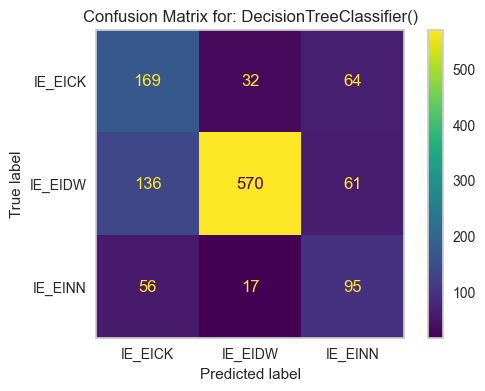

In [98]:
run_CFL(DecisionTreeClassifier(), *Xy_one_hot_resampled)

MODEL:  RandomForestClassifier()
Accuracy:  0.6491666666666667
Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.64      0.50       265
           1       0.89      0.66      0.76       767
           2       0.48      0.59      0.53       168

    accuracy                           0.65      1200
   macro avg       0.59      0.63      0.60      1200
weighted avg       0.72      0.65      0.67      1200



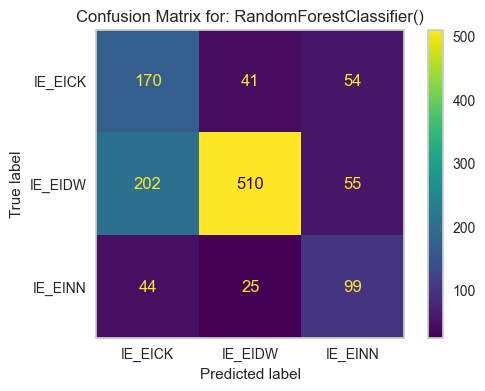

In [100]:
run_CFL(RandomForestClassifier(), *Xy_one_hot_resampled, cols=None)

MODEL:  HistGradientBoostingClassifier()
Accuracy:  0.685
Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.53      0.46       265
           1       0.88      0.76      0.81       767
           2       0.51      0.60      0.55       168

    accuracy                           0.69      1200
   macro avg       0.60      0.63      0.61      1200
weighted avg       0.72      0.69      0.70      1200



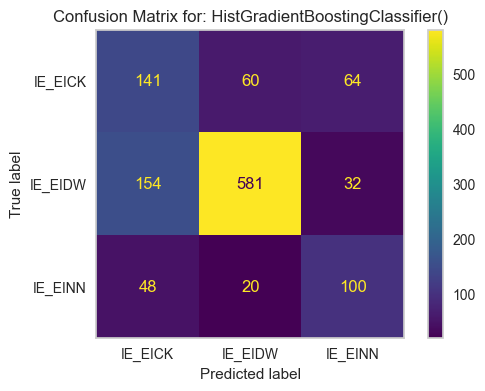

In [101]:
run_CFL(HistGradientBoostingClassifier(), *Xy_one_hot_resampled, cols=None)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 1/5] END .......................max_iter=10;, score=0.391 total time=  26.4s
[CV 2/5] END .......................max_iter=10;, score=0.542 total time=  26.9s
[CV 3/5] END .......................max_iter=10;, score=0.596 total time=  27.9s
[CV 4/5] END .......................max_iter=10;, score=0.474 total time=  28.1s
[CV 5/5] END .......................max_iter=10;, score=0.435 total time=  24.9s
[CV 1/5] END .......................max_iter=20;, score=0.348 total time=  46.5s
[CV 2/5] END .......................max_iter=20;, score=0.547 total time=  51.1s
[CV 3/5] END .......................max_iter=20;, score=0.575 total time=  52.7s
[CV 4/5] END .......................max_iter=20;, score=0.522 total time=  49.6s
[CV 5/5] END .......................max_iter=20;, score=0.447 total time=  49.9s
[CV 1/5] END .......................max_iter=50;, score=0.331 total time= 1.8min
[CV 2/5] END .......................max_iter=50;, score=0.561 total time= 1.8min
[CV 3/5] END ...............

779

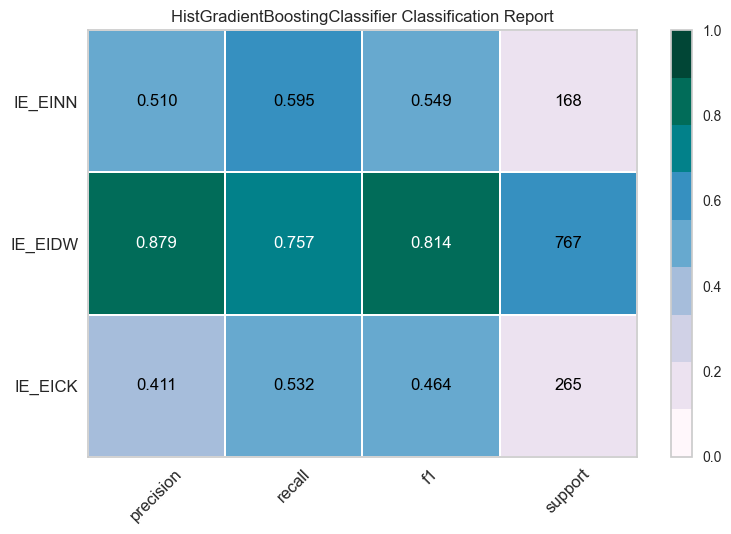

In [107]:
res = run_GridSearch(HistGradientBoostingClassifier(), 
                    {"max_iter": [10, 20, 50, 100, 300, 500]},
                    *Xy_one_hot_resampled)

with open('cross-val/HistGradientBoostingClassifier-OneHot-GridSearch.txt', 'w') as f:
    f.write(res)

In [ ]:
res = run_GridSearch(SVC(), 
                     {'C':[0.1,1,10],
                      'gamma':[1,0.1,0.01], 
                      'kernel':['rbf','linear','poly']},
                      **Xy_one_hot_resampled)

with open('cross-val/SVC-OneHot-GridSearch.txt', 'w') as f:
    f.write(res)

## Without Scaling

In [92]:
merged_df_sampled = merged_df_processed.sample(n=2000)
X_s = merged_df_sampled[X_COLS]
y_s = merged_df_sampled['domestic_airport']

X_train_not_processed, X_test_not_processed, y_train_not_processed, y_test_not_processed = split_encode_scale(X_s, y_s, None, None)

# Resample the data after having applied the different scaler
# nr = NearMiss()
# X_train_one_hot_resampled, y_train_one_hot_resampled = nr.fit_resample(X_train_one_hot, y_train_one_hot)
# X_train_one_hot_resampled.shape
# y_train_one_hot_resampled.shape

In [93]:
Xy_not_processed = X_train_not_processed, y_train_not_processed, X_test_not_processed, y_test_not_processed 

In [94]:
run_CFL(HistGradientBoostingClassifier(categorical_features=["direction", "international_airport"]), *Xy_not_processed)

MODEL:  HistGradientBoostingClassifier(categorical_features=['direction',
                                                     'international_airport'])
Accuracy:  0.89
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.81        92
           1       0.95      0.96      0.96       251
           2       0.72      0.74      0.73        57

    accuracy                           0.89       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.89      0.89      0.89       400

Permutation Importances: 



TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV 2/5] END ........................max_iter=5;, score=0.905 total time=   0.5s
[CV 1/5] END ........................max_iter=5;, score=0.894 total time=   0.6s
[CV 3/5] END ........................max_iter=5;, score=0.899 total time=   0.4s
[CV 4/5] END ........................max_iter=5;, score=0.904 total time=   0.4s
[CV 5/5] END ........................max_iter=5;, score=0.899 total time=   0.6s
[CV 1/5] END .......................max_iter=10;, score=0.909 total time=   0.7s
[CV 2/5] END .......................max_iter=10;, score=0.925 total time=   0.6s
[CV 3/5] END .......................max_iter=10;, score=0.914 total time=   0.6s
[CV 4/5] END .......................max_iter=10;, score=0.916 total time=   0.5s
[CV 5/5] END .......................max_iter=10;, score=0.913 total time=   0.4s
[CV 1/5] END .......................max_iter=20;, score=0.920 total time=   0.7s
[CV 2/5] END .......................max_iter=20;, score=0.935 total time=   0.7s
[CV 3/5] END ...............

893

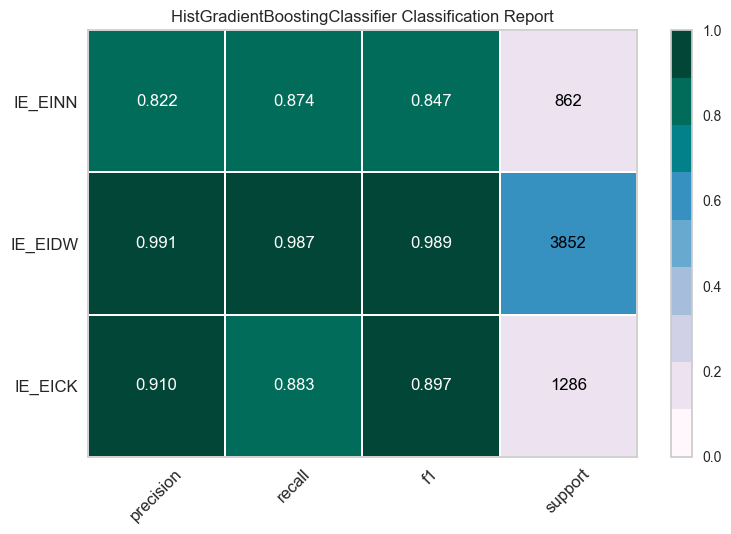

In [74]:
res = run_GridSearch(HistGradientBoostingClassifier(categorical_features=["direction", "international_airport"]), 
                    {"max_iter": [5, 10, 20, 50, 100, 300, 500, 700]},
                    *Xy_not_processed)

with open('cross-val/HistGradientBoostingClassifier-NotProcessed-GridSearch.txt', 'w') as f:
    f.write(res)